# Demand Planning KPI Monitor

In [1]:
import os, sys, gc, datetime, time

import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
from pandas.plotting import register_matplotlib_converters
from pandas import ExcelWriter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib. dates as mdates
%matplotlib inline

import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()

from pyspark.sql import SparkSession
from impala.dbapi import connect

In [2]:
## Get parameters, if not given then fall back to default values

tfmt = '%Y%m%d'
_end = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime(tfmt)

if 'MONITOR_RUN_DATE' in os.environ:
    print('Using external parameters.')
    _end = os.environ.get('MONITOR_RUN_DATE')
else:
    print('Using default parameters.')
    
_start = (datetime.datetime.strptime(_end, '%Y%m%d').date() - datetime.timedelta(days=60)).strftime(tfmt)
date_str = _end

DETENTION_START, DETENTION_END = _start, _end
SERVICE_LEVEL_START, SERVICE_LEVEL_END = _start, _end
STOCK_LEVEL_START, STOCK_LEVEL_END = _start, _end
CONSISTENCY_START, CONSISTENCY_END = _start, _end
OOS_CHECK_DATE = _end

print('Detention:', DETENTION_START, DETENTION_END, sep='\t')
print('Stock level:', STOCK_LEVEL_START, STOCK_LEVEL_END, sep='\t')
print('Consistency:', CONSISTENCY_START, CONSISTENCY_END, sep='\t')
print('Service level:', SERVICE_LEVEL_START, SERVICE_LEVEL_END, sep='\t')
print('OOS_CHECK_DATE:', OOS_CHECK_DATE, sep='\t')

Using default parameters.
Detention:	20190726	20190924
Stock level:	20190726	20190924
Consistency:	20190726	20190924
Service level:	20190726	20190924
OOS_CHECK_DATE:	20190924


In [3]:
record_folder = '/data/jupyter/Carrefour-China-Supply-Chain-Forecast/output/monitoring/'

detention_rate_dc_file = f"report_detention_rate_dc_{date_str}.xlsx"

detention_rate_store_file = f"report_detention_rate_store_{date_str}.xlsx"

stock_level_dc_file = f"report_stock_level_dc_{date_str}.xlsx"

stock_level_store_file = f"report_stock_level_store_{date_str}.xlsx"

service_level_file = f"report_service_level_{date_str}.xlsx"

consistency_file = f'report_consistency_items_{date_str}.xlsx'

oos_file = f'report_oos_item_list_{date_str}.xlsx'

In [4]:
print('Report generation time:', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), end='\n\n')
T0 = time.time()

Report generation time: 2019-09-25 19:48:30



---

In [5]:
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars /data/jupyter/kudu-spark2_2.11-1.8.0.jar pyspark-shell'
warehouse_location = os.path.abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Forecast monitoring process") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.blacklist.enabled", False) \
    .config("spark.driver.memory", '6g') \
    .config("spark.executor.memory", '6g') \
    .config("spark.num.executors", '14') \
    .enableHiveSupport() \
    .getOrCreate()

In [6]:
kudu_tables = [
    'lfms.daily_dctrxn', 'lfms.daily_dcstock', 'lfms.ord', 'lfms.daily_shipment'
]

for tbl in kudu_tables:
    spark.read.format('org.apache.kudu.spark.kudu') \
    .option('kudu.master', "dtla1apps11:7051,dtla1apps12:7051,dtla1apps13:7051") \
    .option('kudu.table', f'impala::{tbl}') \
    .load() \
    .registerTempTable('{}'.format(tbl.replace('.', '_')))

In [7]:
def get_query(sql_path, kudu_replace=None, **query_params):
    with open(sql_path, 'r') as f:
        query = f.read()
    if kudu_replace is not None:
        for k, v in kudu_replace.items():
            query = query.replace(k, v)
   
    query = query.format(**query_params)

    return query

In [8]:
def read_query_and_fetch(sql_path, create_table=False, get_query=False, kudu_replace=None, **query_params):
    with open(sql_path, 'r') as f:
        query = f.read()
    if kudu_replace is not None:
        for k, v in kudu_replace.items():
            query = query.replace(k, v)
    if not create_table:
        ## remove lines with `table`
        q0 = query
        query = '\n'.join([line for line in q0.split('\n')
                           if ('drop table' not in line.lower())
                           and ('create table' not in line.lower())])
    query = query.format(**query_params)
    if get_query:
        return query
    return spark.sql(query).toPandas()

In [9]:
def run_sql_with_impala(sql):
    with connect(host='dtla1apps14', port=21050, auth_mechanism='PLAIN', user='CHEXT10211', password='datalake2019',
                 database='vartefact') as conn:
        curr = conn.cursor()
        curr.execute(sql)

In [10]:
dc_stock_sql = get_query(
    'sql/record_dc_stock.sql',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END
)

In [11]:
run_sql_with_impala(dc_stock_sql.replace("\n", " "))

In [12]:
store_stock_sql = get_query(
    'sql/record_store_stock.sql',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END
)

In [13]:
run_sql_with_impala(store_stock_sql.replace("\n", " "))

---

# 1. Detention rate

### 1.1 Detention rate - DC

In [14]:
detention_dc = spark.sql(get_query(
    'sql/kpi_detention_rate_dc.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [15]:
detention_dc_supplier = spark.sql(get_query(
    'sql/kpi_detention_rate_dc_supplier.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [16]:
detention_dc_writer = ExcelWriter(record_folder + detention_rate_dc_file)

In [17]:
def plot_detention_dc(df, title):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12, 3))
    flow_A = df1[df1.rotation == 'A']
    flow_B = df1[df1.rotation == 'B']
    ax.plot(flow_A.date_dt, flow_A.detention_rate, label='Flow A')
    ax.plot(flow_B.date_dt, flow_B.detention_rate, label='Flow B')
    ax.legend()
    ax.set_title(f'DC detention rate for {title}')
    fig.autofmt_xdate()
    
    print(f'Latest detention rate for {title}:')
    display(df[['date_key', 'rotation', 'detention_rate']].tail(9).style.hide_index())
    
    df1.to_excel(detention_dc_writer, sheet_name=title, index=False)

Latest detention rate for all items:


date_key,rotation,detention_rate
20190920,B,0.914141
20190921,A,0.948905
20190921,B,0.909091
20190922,A,0.963504
20190922,B,0.909091
20190923,A,0.956204
20190923,B,0.883838
20190924,A,0.948905
20190924,B,0.873737


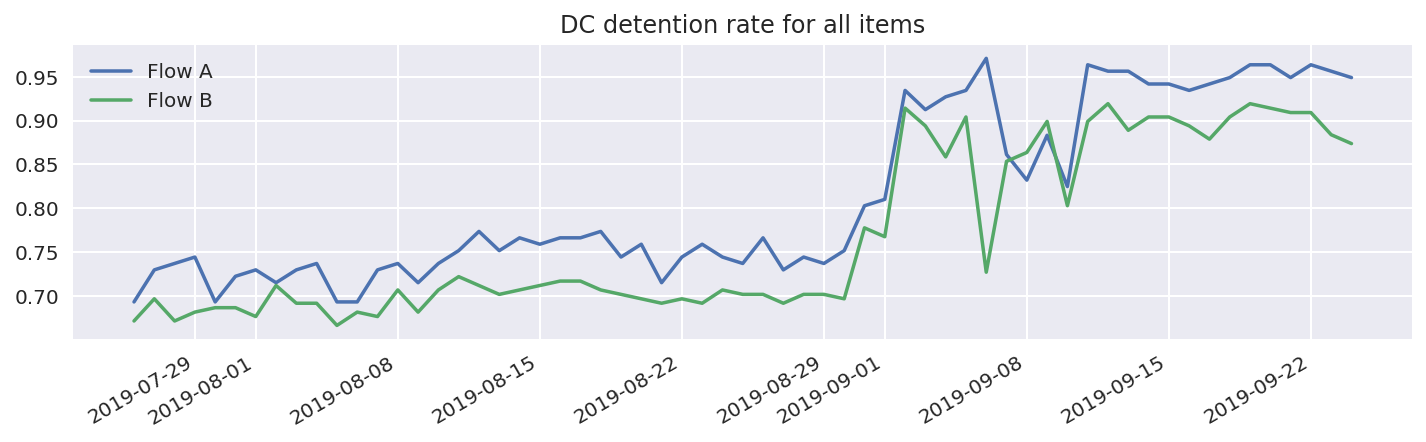

In [18]:
plot_detention_dc(detention_dc, 'all items')

Latest detention rate for Nestle:


date_key,rotation,detention_rate
20190920,B,0.847826
20190921,A,1
20190921,B,0.847826
20190922,A,1
20190922,B,0.826087
20190923,A,1
20190923,B,0.847826
20190924,A,1
20190924,B,0.869565


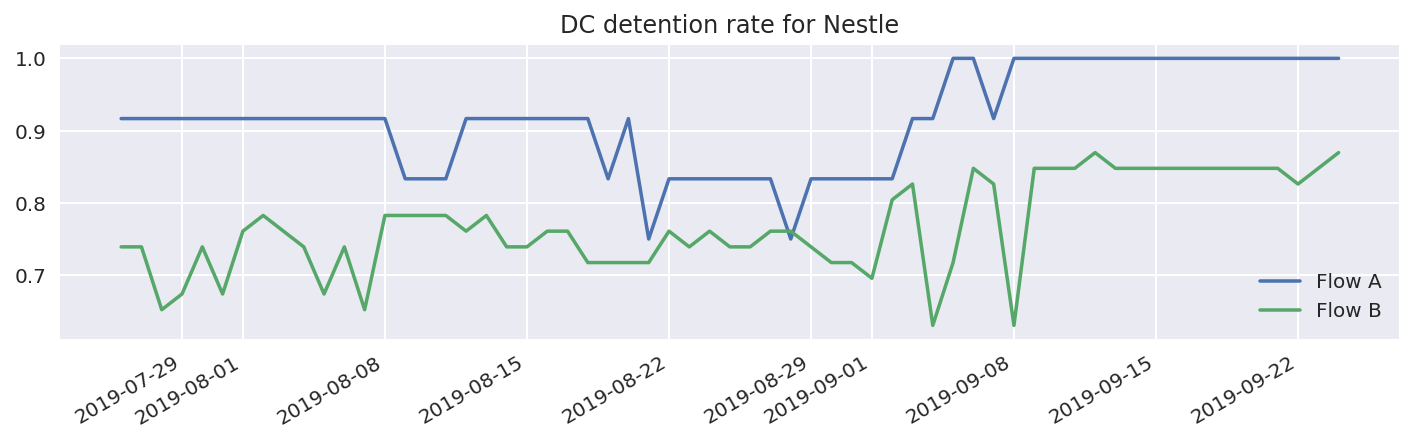

In [19]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '002'], 'Nestle')

Latest detention rate for P&G:


date_key,rotation,detention_rate
20190920,B,0.93617
20190921,A,1
20190921,B,0.93617
20190922,A,1
20190922,B,0.93617
20190923,A,1
20190923,B,0.904255
20190924,A,1
20190924,B,0.893617


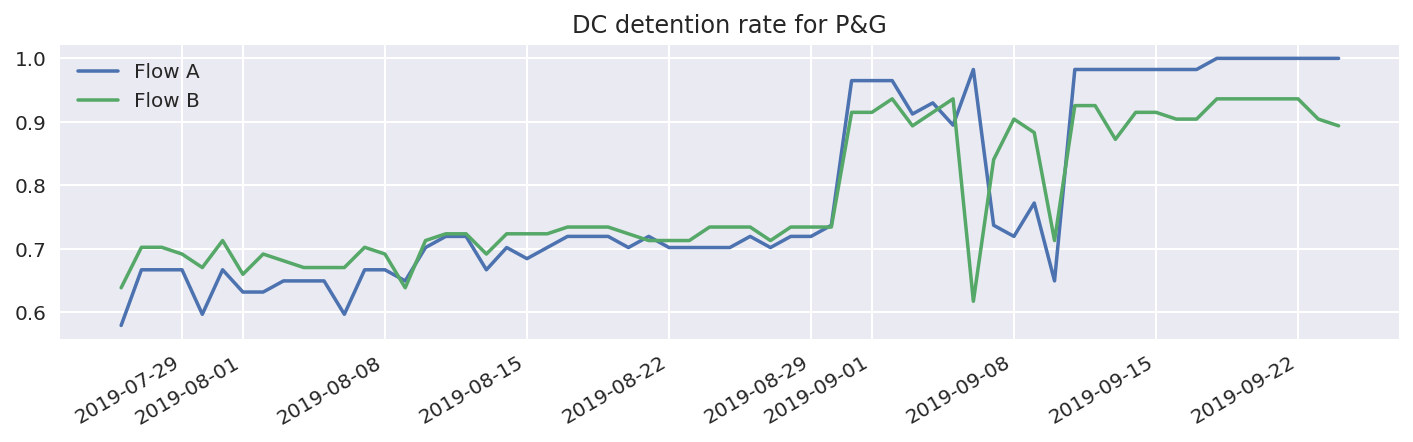

In [20]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '693'], 'P&G')

Latest detention rate for Unilever:


date_key,rotation,detention_rate
20190920,B,0.931034
20190921,A,0.897059
20190921,B,0.913793
20190922,A,0.926471
20190922,B,0.931034
20190923,A,0.911765
20190923,B,0.87931
20190924,A,0.897059
20190924,B,0.844828


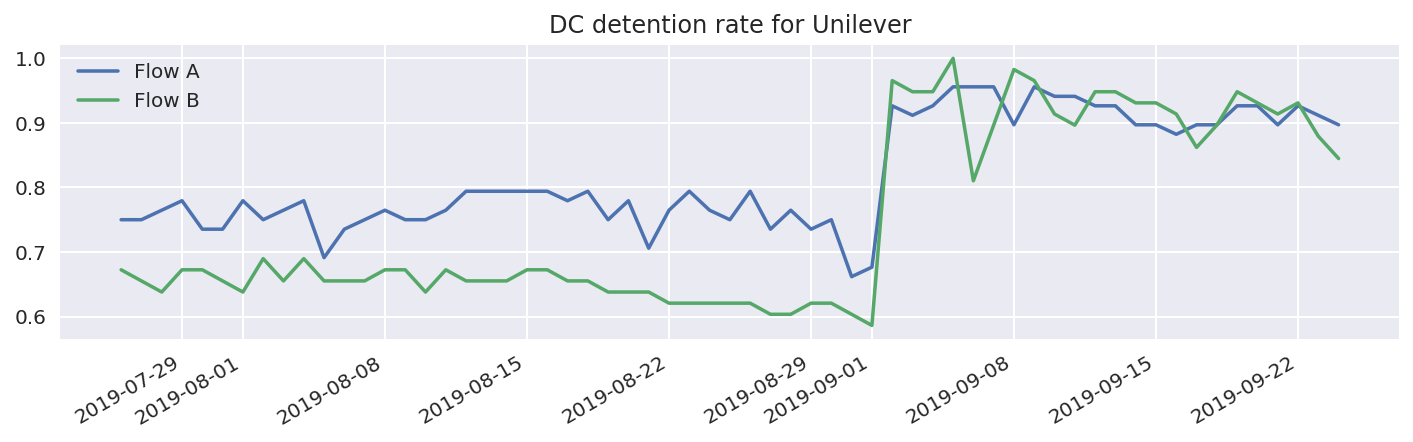

In [21]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '700'], 'Unilever')

In [22]:
detention_dc_writer.save()
print(f'Please check file {detention_rate_dc_file} for detail')

Please check file report_detention_rate_dc_20190924.xlsx for detail


---

### 1.2 Detention rate - Store

In [23]:
detention_all_store = spark.sql(get_query(
    'sql/kpi_detention_rate_all_store.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [24]:
detention_store_supplier = spark.sql(get_query(
    'sql/kpi_detention_rate_store_supplier.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [25]:
detention_store = spark.sql(get_query(
    'sql/kpi_detention_rate_store.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [26]:
detention_store_writer = ExcelWriter(record_folder + detention_rate_store_file)

In [27]:
def plot_detention_all_store(df, title):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12, 3))
    flow_A = df1[df1.rotation == 'A']
    flow_B = df1[df1.rotation == 'B']
    flow_X = df1[df1.rotation == 'X']
    ax.plot(flow_A.date_dt, flow_A.detention_rate, label='Flow A')
    ax.plot(flow_B.date_dt, flow_B.detention_rate, label='Flow B')
    ax.plot(flow_X.date_dt, flow_X.detention_rate, label='Flow X')
    ax.legend()
    ax.set_title(f'{title} store detention rate by day')
    fig.autofmt_xdate()
    print(f'Latest detention rate:')

    display(df[['date_key', 'rotation', 'detention_rate']].tail(9).style.hide_index())
    
    flow_A.to_excel(detention_store_writer, sheet_name=f"{title} Flow A", index=False)
    flow_B.to_excel(detention_store_writer, sheet_name=f"{title} Flow B", index=False)
    flow_X.to_excel(detention_store_writer, sheet_name=f"{title} Flow X", index=False)

In [28]:
def plot_detention_store(df):
    df1 = df.sort_values(by=['rotation', 'date_key', 'store_code']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')

    dr = df1.groupby(['store_code', 'rotation'])['detention_rate'].mean().reset_index()
    a = dr.loc[dr.rotation == 'A', 'detention_rate'].sort_values().values
    b = dr.loc[dr.rotation == 'B', 'detention_rate'].sort_values().values
    x = dr.loc[dr.rotation == 'X', 'detention_rate'].sort_values().values
    
    fig, axes = plt.subplots(figsize=(16, 4), ncols=3)

    axes[0].plot(a, 'o', ms=6)
    axes[1].plot(b, 'o', ms=6)
    axes[2].plot(x, 'o', ms=6)
    
    axes[0].set_title('Store detention rate by store: Flow A')
    axes[1].set_title('Store detention rate by store: Flow B')
    axes[2].set_title('Store detention rate by store: Flow X')
    
    axes[0].set_ylim(min(0.75, a.min()), 1)
    axes[1].set_ylim(min(0.75, b.min()), 1)
    axes[2].set_ylim(min(0.75, x.min()), 1)
    
    fig.tight_layout()
    
    df1[df1.rotation == 'A'].to_excel(detention_store_writer, sheet_name="By store flow A", index=False)
    df1[df1.rotation == 'B'].to_excel(detention_store_writer, sheet_name="By store flow B", index=False)
    df1[df1.rotation == 'X'].to_excel(detention_store_writer, sheet_name="By store flow X", index=False)

Latest detention rate:


date_key,rotation,detention_rate
20190922,A,0.962592
20190922,B,0.967234
20190922,X,0.937216
20190923,A,0.95915
20190923,B,0.964236
20190923,X,0.934099
20190924,A,0.951818
20190924,B,0.957276
20190924,X,0.926861


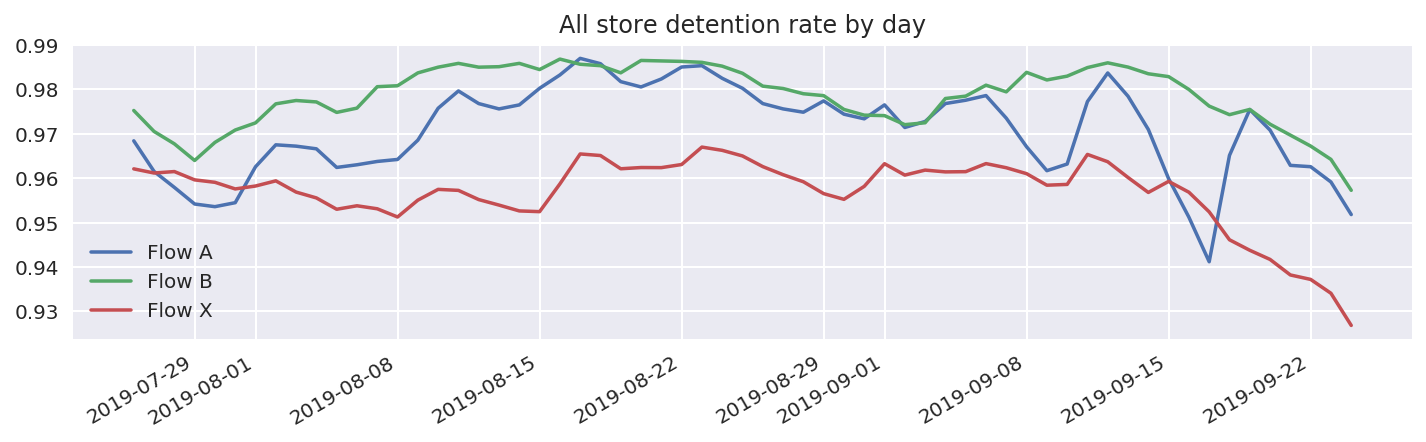

In [29]:
plot_detention_all_store(detention_all_store, "All")

Latest detention rate:


date_key,rotation,detention_rate
20190922,A,0.99529
20190922,B,0.97267
20190922,X,0.90049
20190923,A,0.992151
20190923,B,0.970229
20190923,X,0.893568
20190924,A,0.990581
20190924,B,0.968765
20190924,X,0.885203


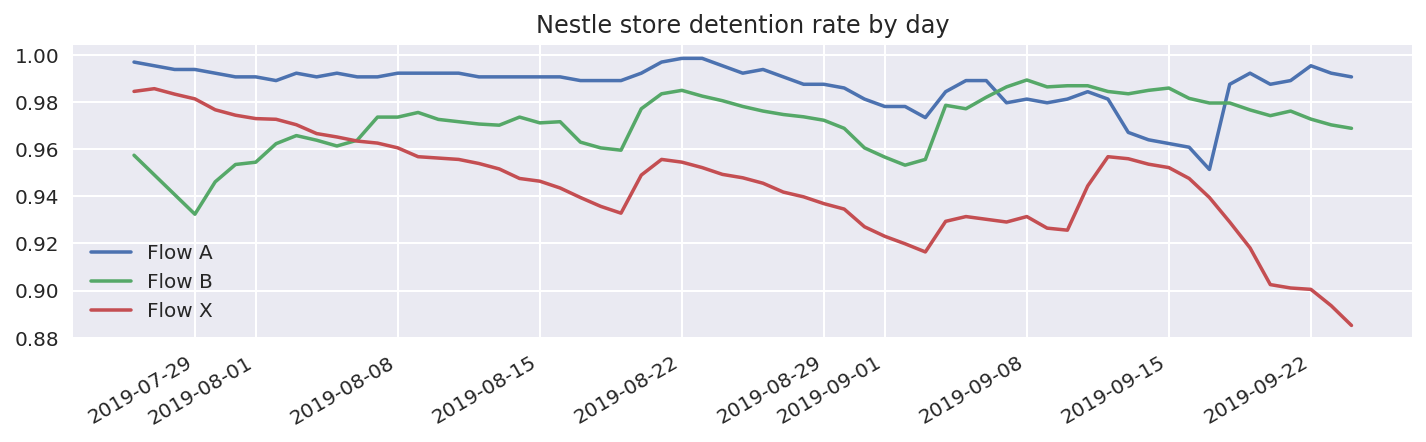

In [30]:
plot_detention_all_store(detention_store_supplier[detention_store_supplier['con_holding'] == '002'], "Nestle")

Latest detention rate:


date_key,rotation,detention_rate
20190922,A,0.972303
20190922,B,0.957031
20190922,X,0.938373
20190923,A,0.970481
20190923,B,0.953993
20190923,X,0.935605
20190924,A,0.970845
20190924,B,0.94401
20190924,X,0.929032


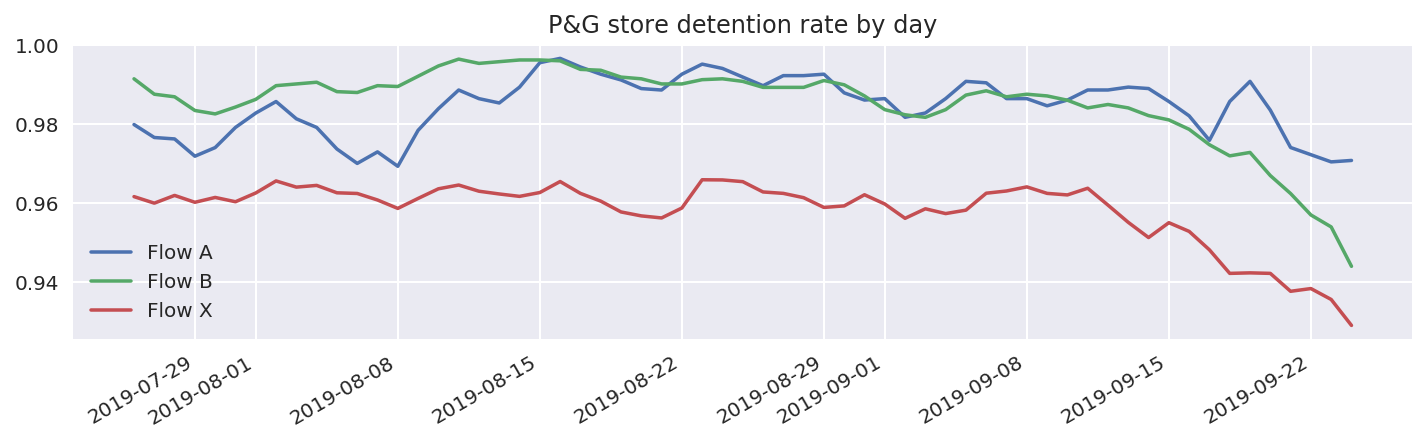

In [31]:
plot_detention_all_store(detention_store_supplier[detention_store_supplier['con_holding'] == '693'], "P&G")

Latest detention rate:


date_key,rotation,detention_rate
20190922,A,0.948213
20190922,B,0.980611
20190922,X,0.944836
20190923,A,0.943368
20190923,B,0.977256
20190923,X,0.942108
20190924,A,0.928528
20190924,B,0.97129
20190924,X,0.934


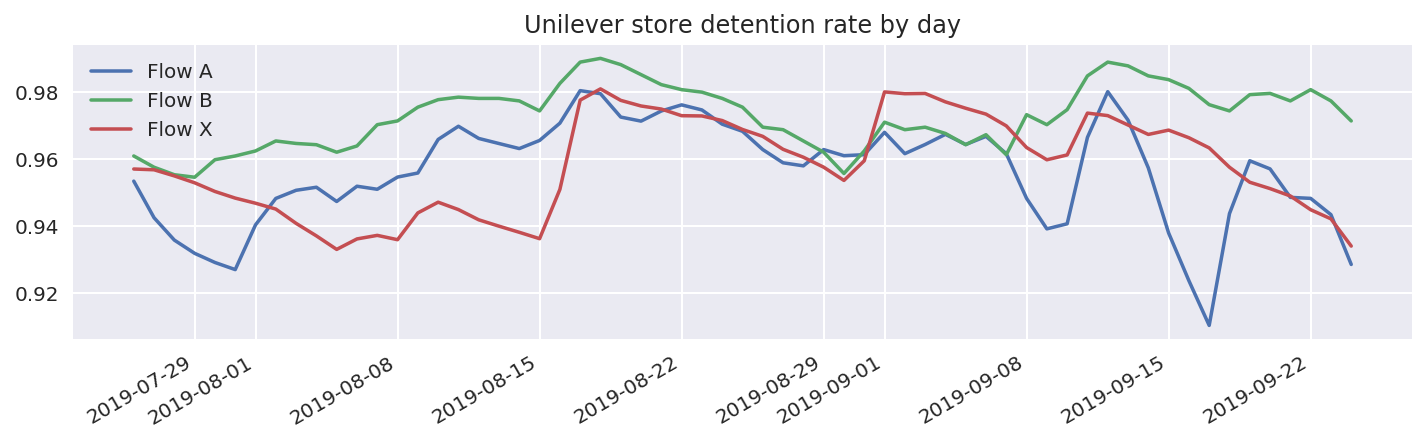

In [32]:
plot_detention_all_store(detention_store_supplier[detention_store_supplier['con_holding'] == '700'], "Unilever")

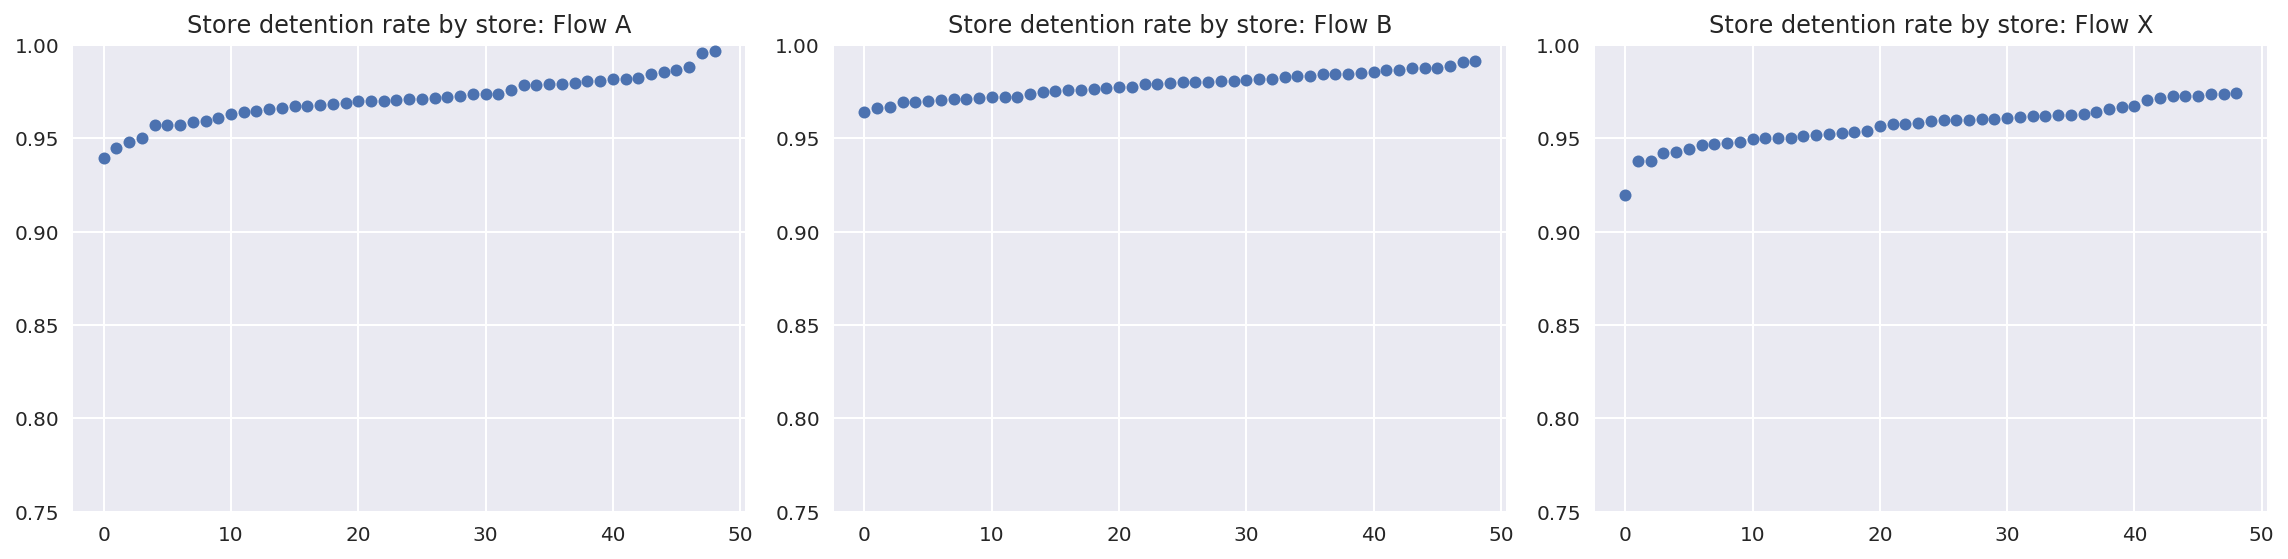

In [33]:
plot_detention_store(detention_store) 

In [34]:
detention_store_writer.save()
print(f'Please check file {detention_rate_store_file} for detail')

Please check file report_detention_rate_store_20190924.xlsx for detail


---

## 2 Stock level

### 2.1 Stock level - DC

In [35]:
stock_level_dc = spark.sql(get_query(
    'sql/kpi_stock_level_dc.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [36]:
stock_dc_writer = ExcelWriter(record_folder + stock_level_dc_file)

In [37]:
def plot_stock_level_dc(df, title):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    sl = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl['date_key'] = pd.to_datetime(sl.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    for i, rotation in enumerate(['A', 'B']):
        axes[i].set_title(f'DC stock level {title} Rotation {rotation}')
        for dm in sl.in_dm.unique():
            d = sl[(sl.in_dm == dm) & (sl.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    
    sl_value = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_value'].sum().reset_index()
    sl_value['date_key'] = pd.to_datetime(sl_value.date_key, format='%Y%m%d')
    fig_value, axes_value = plt.subplots(figsize=(12, 4), ncols=2)
    for i, rotation in enumerate(['A', 'B']):
        axes_value[i].set_title(f'DC stock value {title} Rotation {rotation}')
        for dm in sl_value.in_dm.unique():
            d = sl_value[(sl_value.in_dm == dm) & (sl_value.rotation == rotation)]
            axes_value[i].plot(d.date_key, d.stock_value, label="DM" if dm else "Non-DM")
            axes_value[i].legend()
    fig_value.autofmt_xdate(); fig_value.tight_layout()
    
    df1.to_excel(stock_dc_writer, sheet_name=title, index=False)

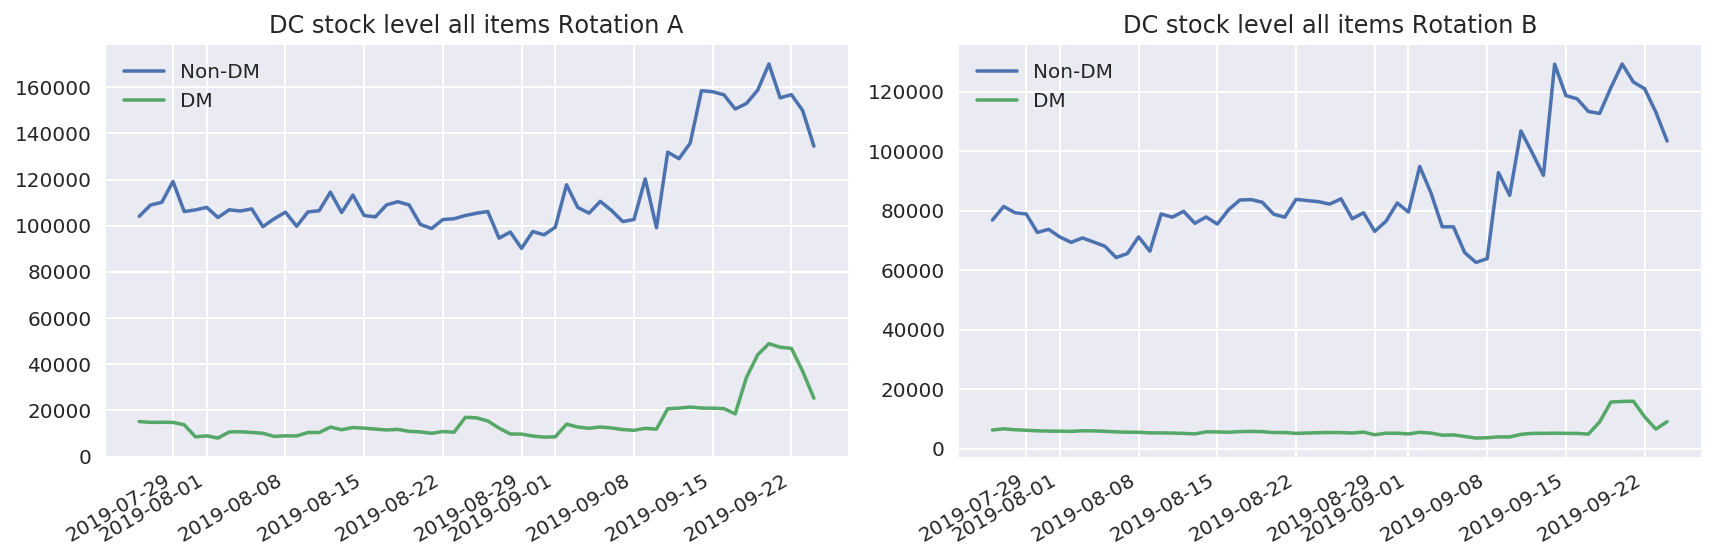

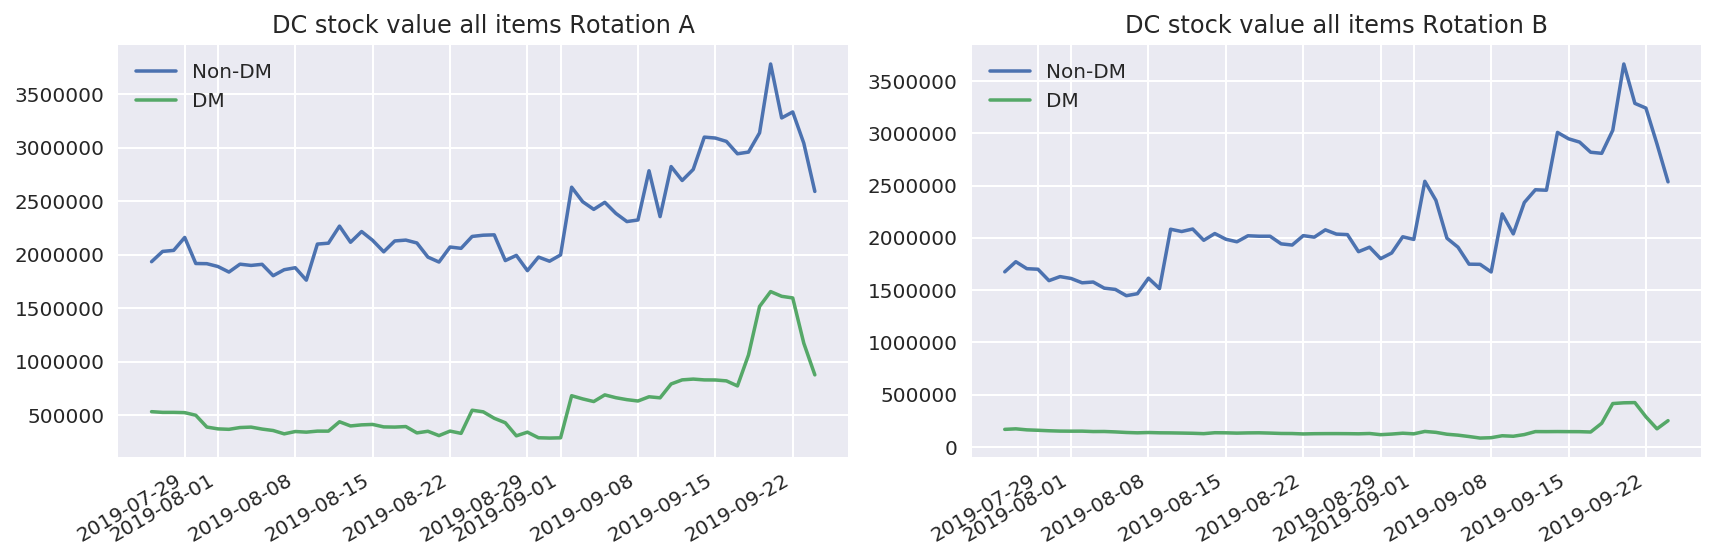

In [38]:
plot_stock_level_dc(stock_level_dc, 'all items')

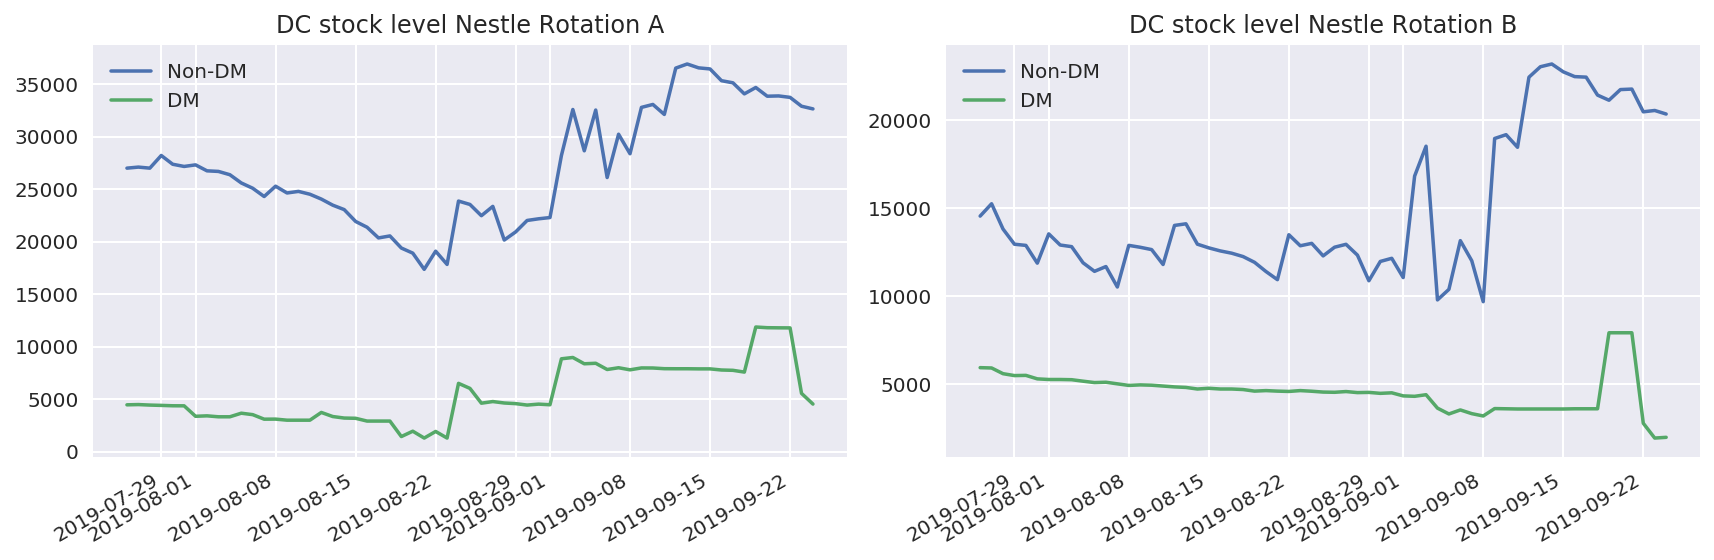

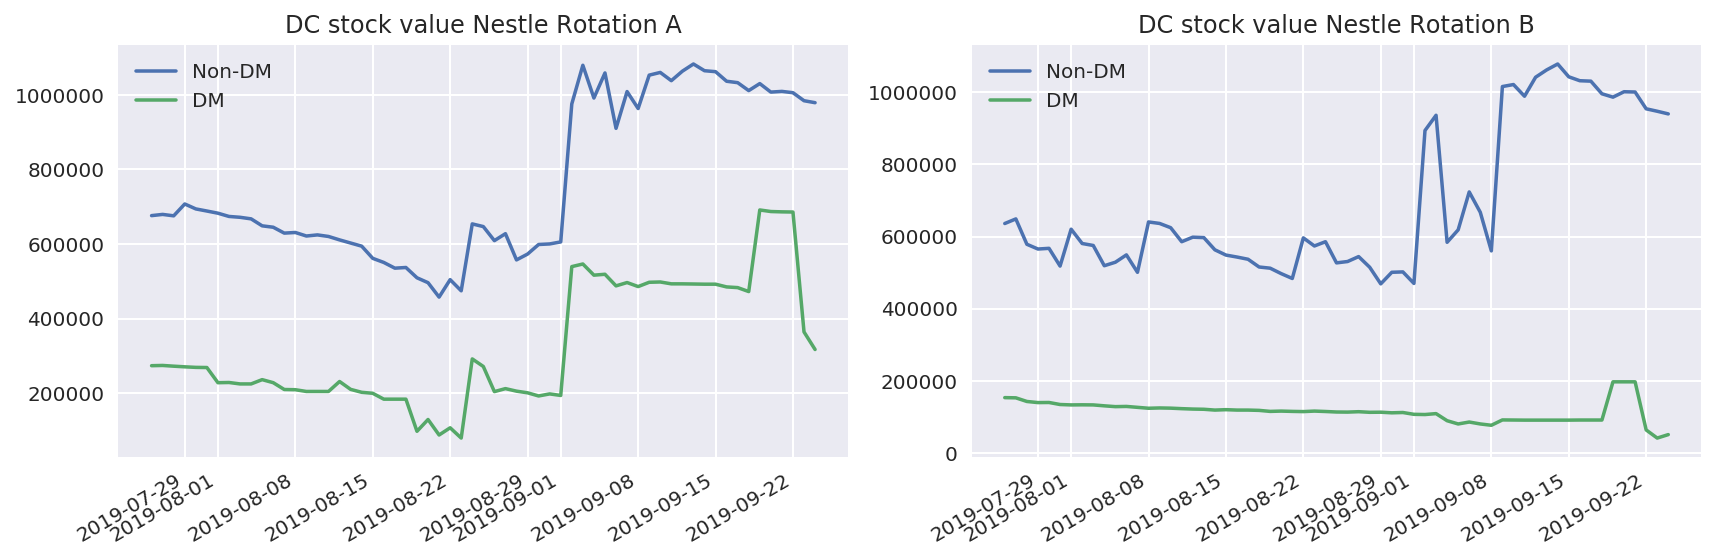

In [39]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '002'], 'Nestle')

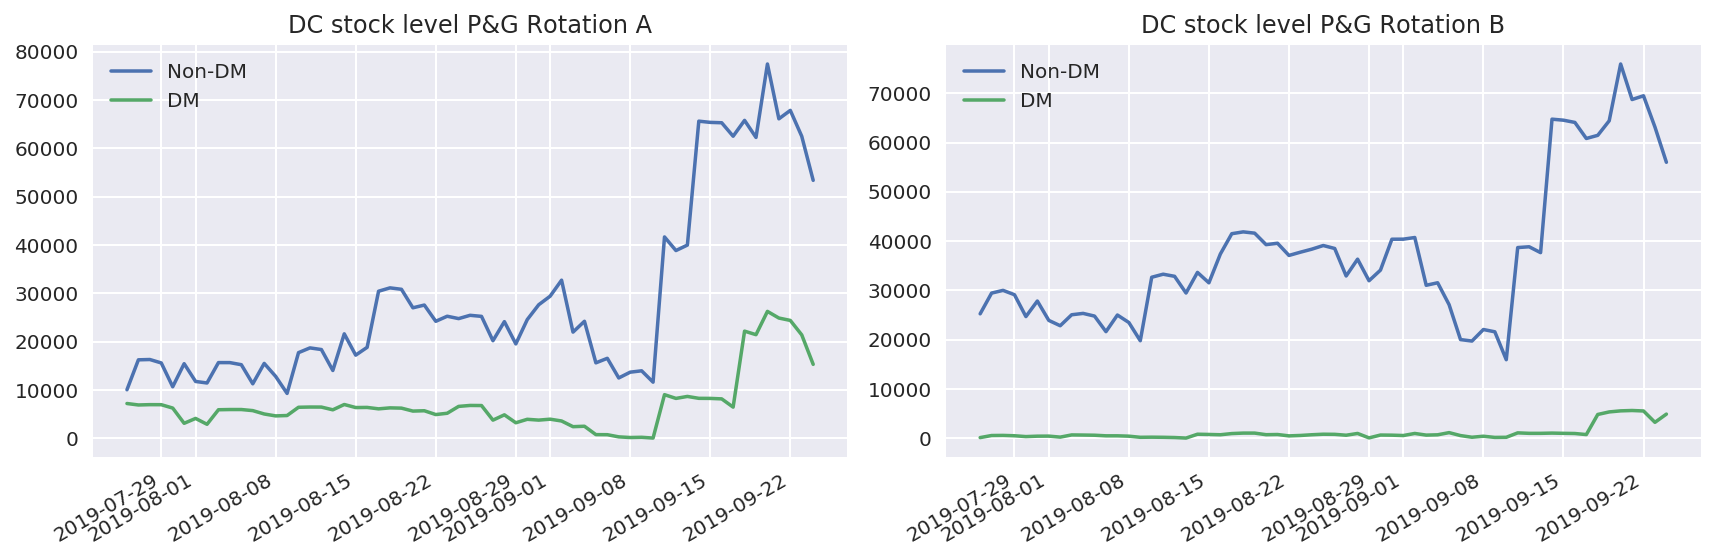

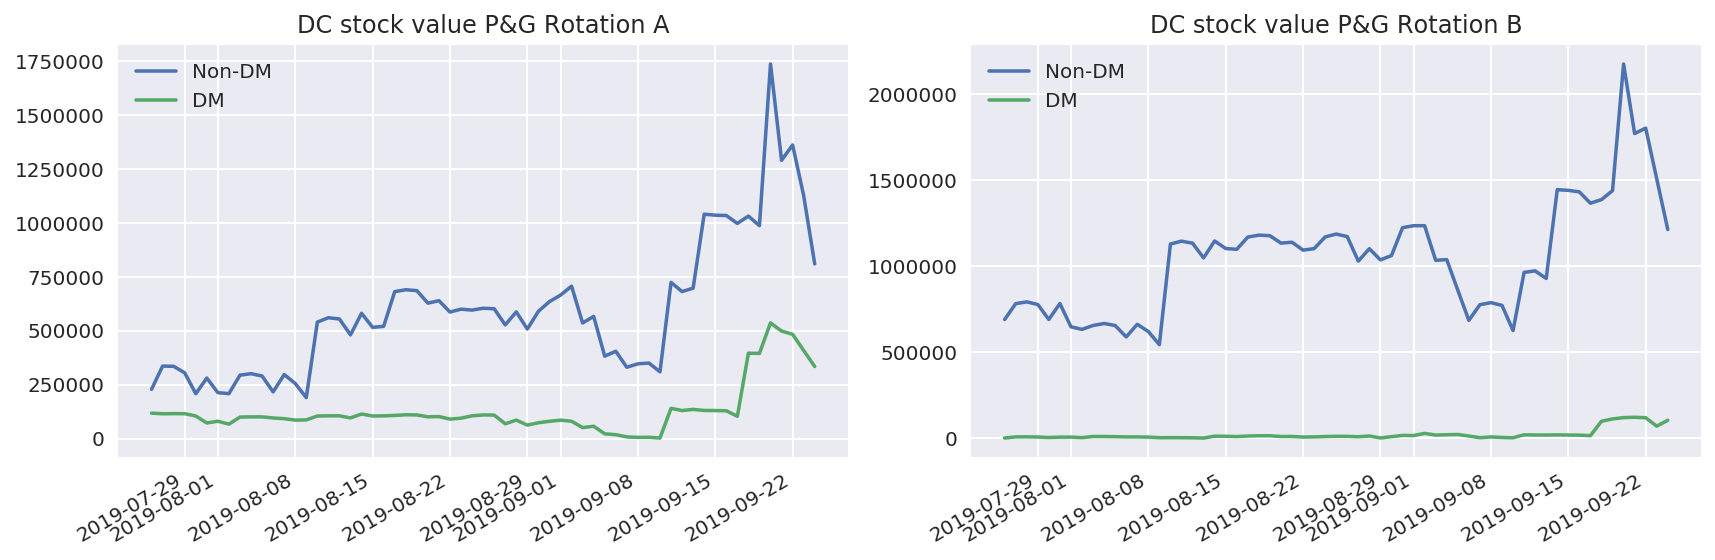

In [40]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '693'], 'P&G')

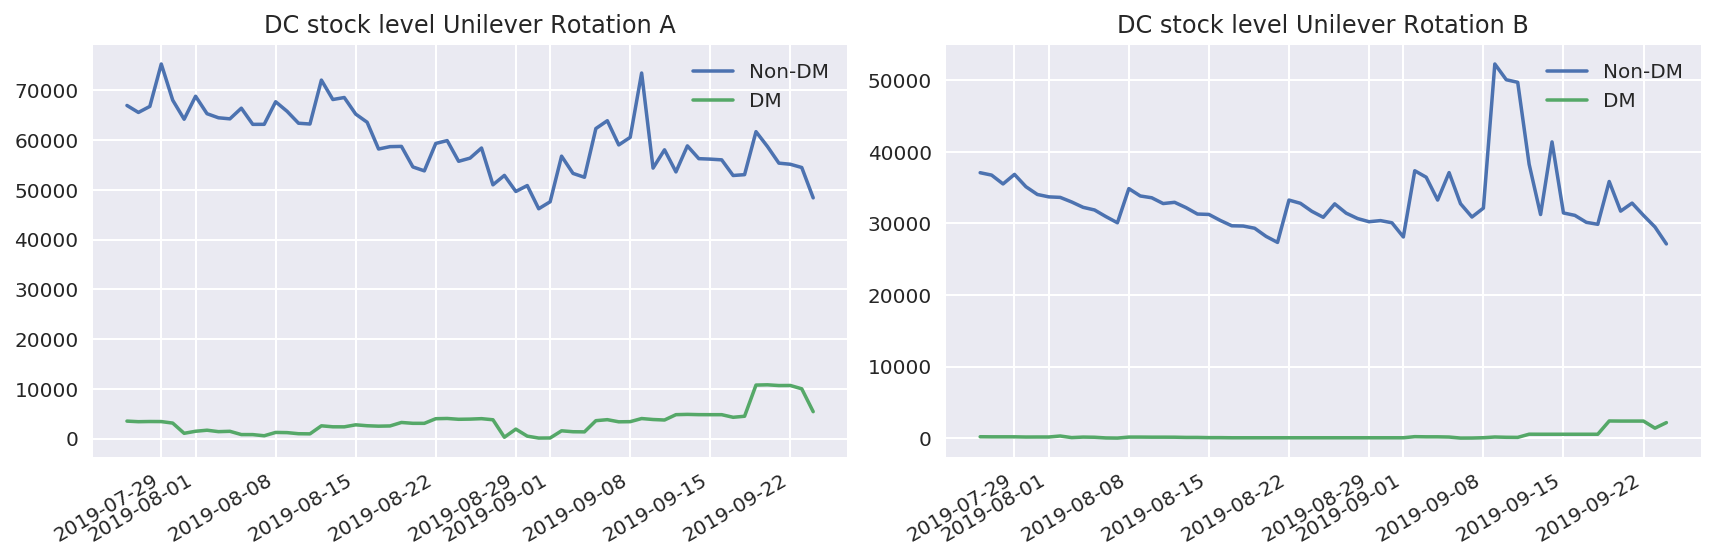

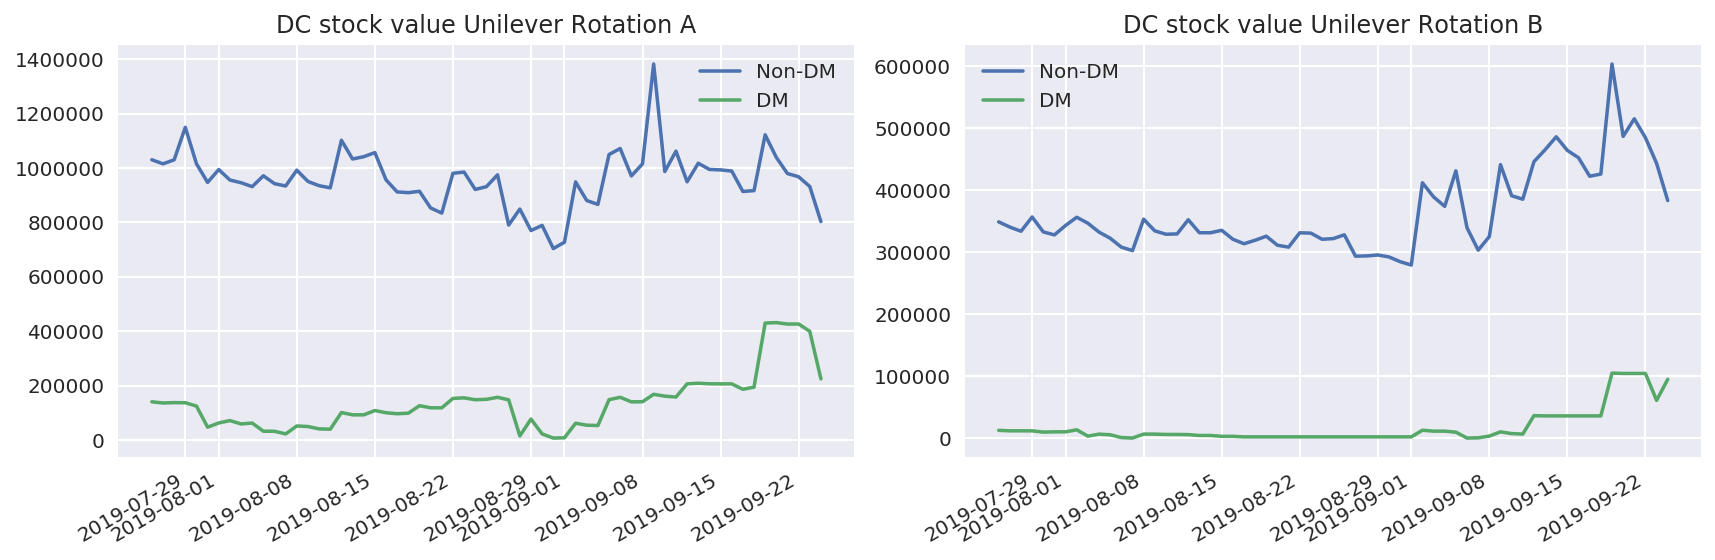

In [41]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '700'], 'Unilever')

In [42]:
stock_dc_writer.save()
print(f'Please check file {stock_level_dc_file} for detail')

Please check file report_stock_level_dc_20190924.xlsx for detail


---

### 2.2  Stock level - store

In [43]:
stock_level_store = spark.sql(get_query(
    'sql/kpi_stock_level_store.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [44]:
stock_store_writer = ExcelWriter(record_folder + stock_level_store_file)

In [45]:
def plot_stock_level_store(df, title):
    df1 = df.sort_values(by=['store_code', 'rotation', 'date_key']).copy()
    sl_all_stores = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl_all_stores['date_key'] = pd.to_datetime(sl_all_stores.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(14, 3.5), ncols=3)
    for i, rotation in enumerate(sl_all_stores.rotation.unique()):
        axes[i].set_title(f'Store stock for {title} Rotation {rotation}')
        for dm in sl_all_stores.in_dm.unique():
            d = sl_all_stores[(sl_all_stores.in_dm == dm) & (sl_all_stores.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    
    sl_value = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_value'].sum().reset_index()
    sl_value['date_key'] = pd.to_datetime(sl_value.date_key, format='%Y%m%d')
    fig_value, axes_value = plt.subplots(figsize=(14, 3.5), ncols=3)
    for i, rotation in enumerate(sl_all_stores.rotation.unique()):
        axes_value[i].set_title(f'Store stock value {title} Rotation {rotation}')
        for dm in sl_value.in_dm.unique():
            d = sl_value[(sl_value.in_dm == dm) & (sl_value.rotation == rotation)]
            axes_value[i].plot(d.date_key, d.stock_value, label="DM" if dm else "Non-DM")
            axes_value[i].legend()
    fig_value.autofmt_xdate(); fig_value.tight_layout()
    
    df1.to_excel(stock_store_writer, sheet_name=title, index=False)

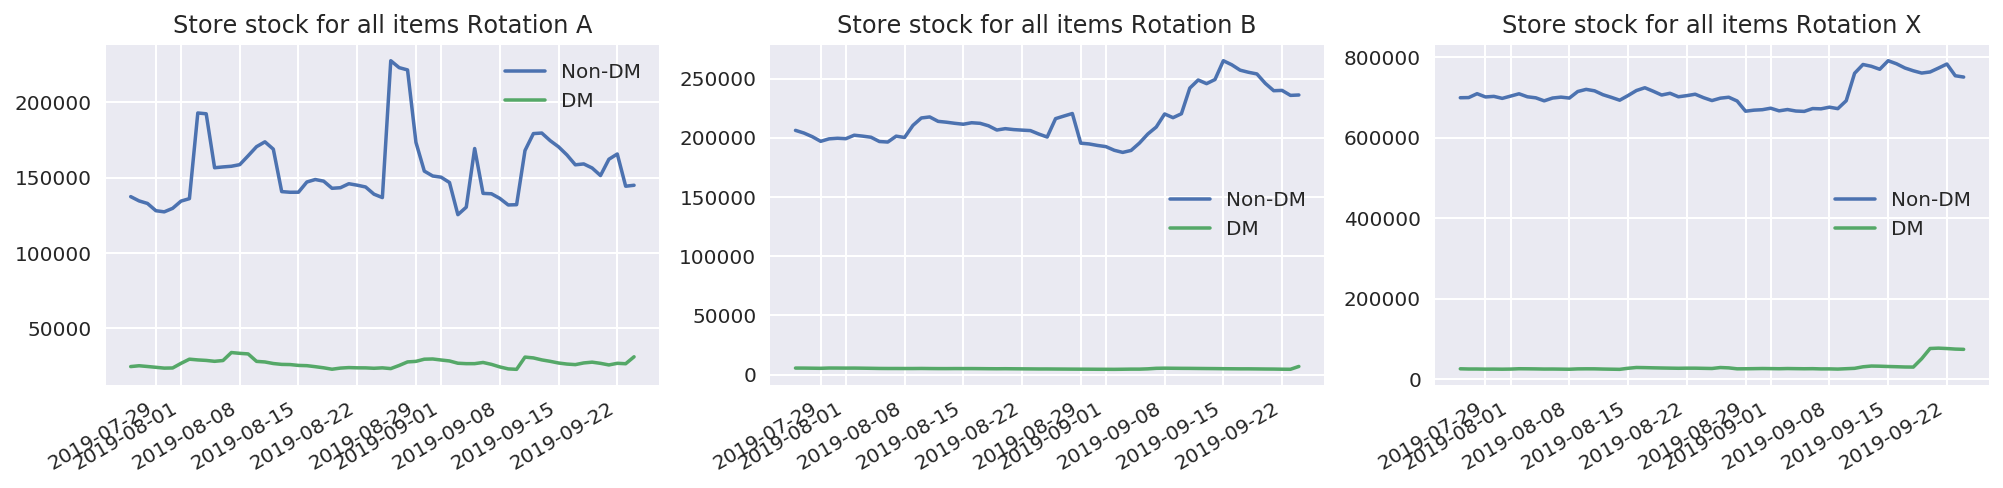

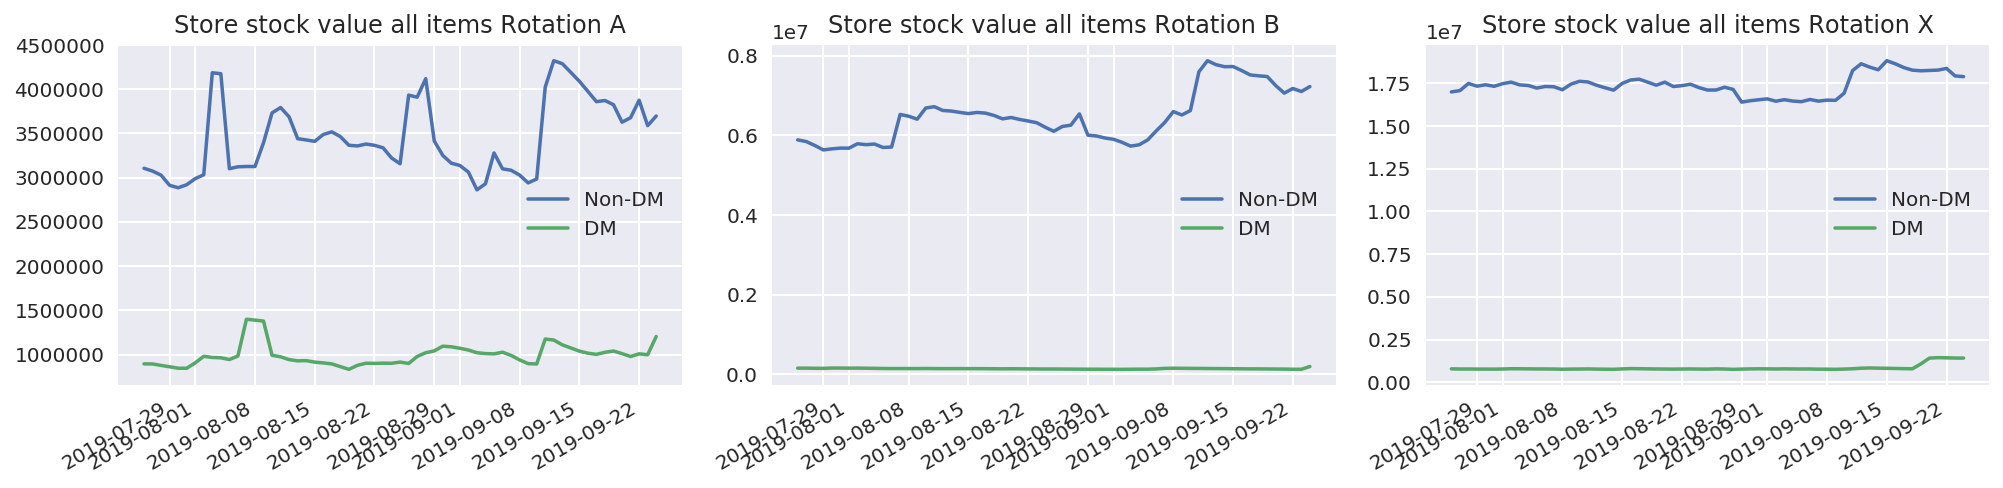

In [46]:
plot_stock_level_store(stock_level_store, "all items")

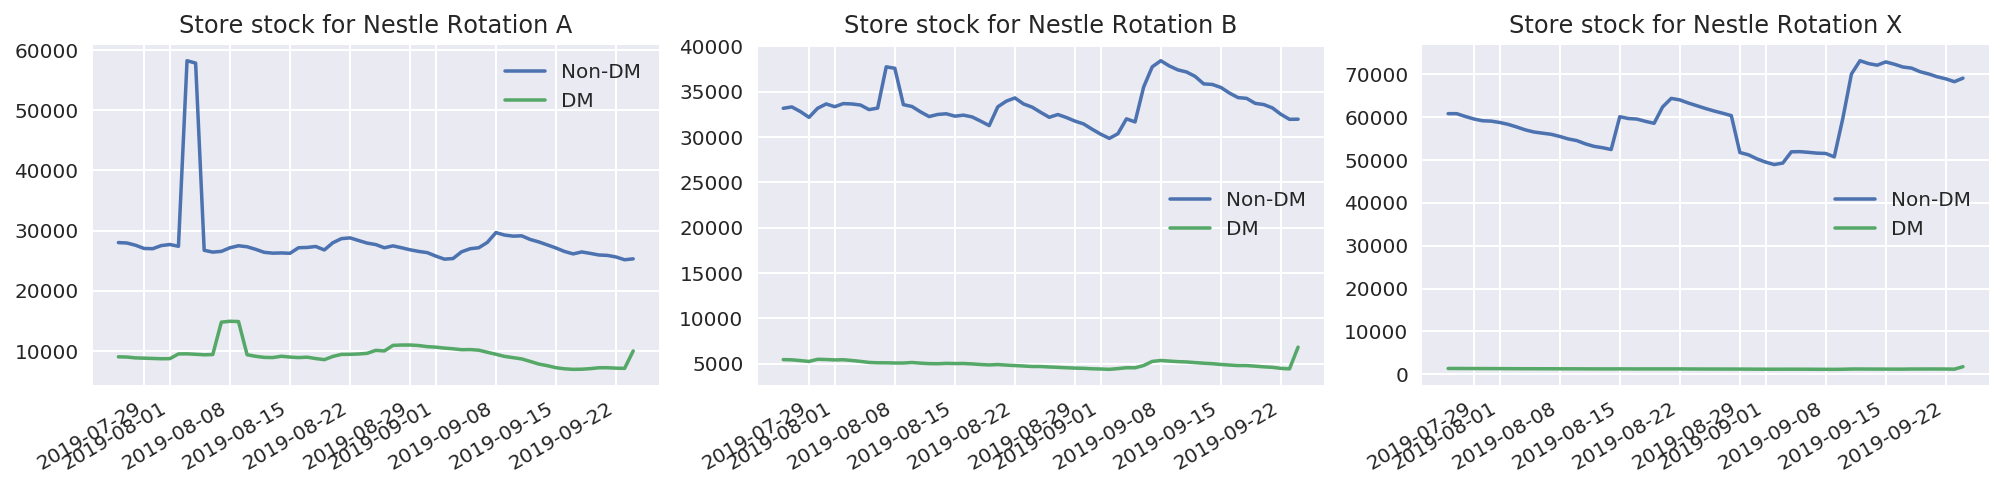

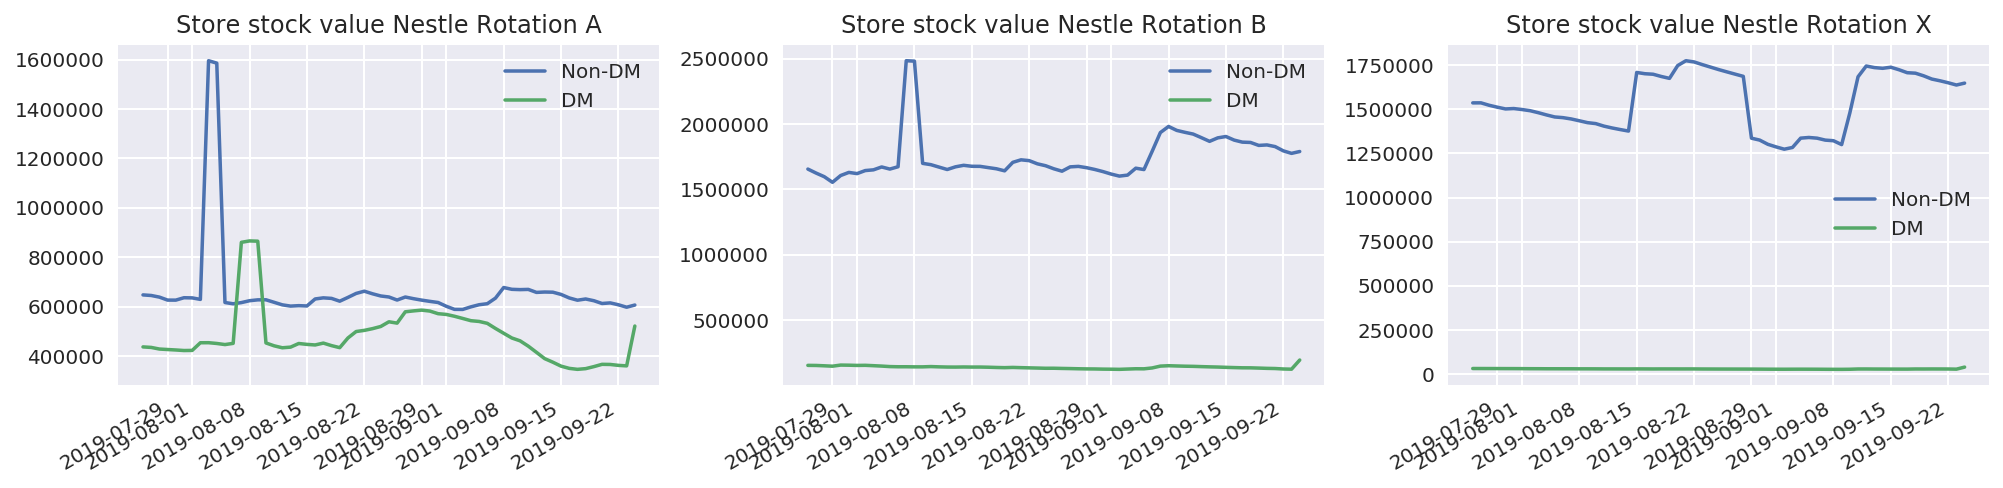

In [47]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '002'], 'Nestle')

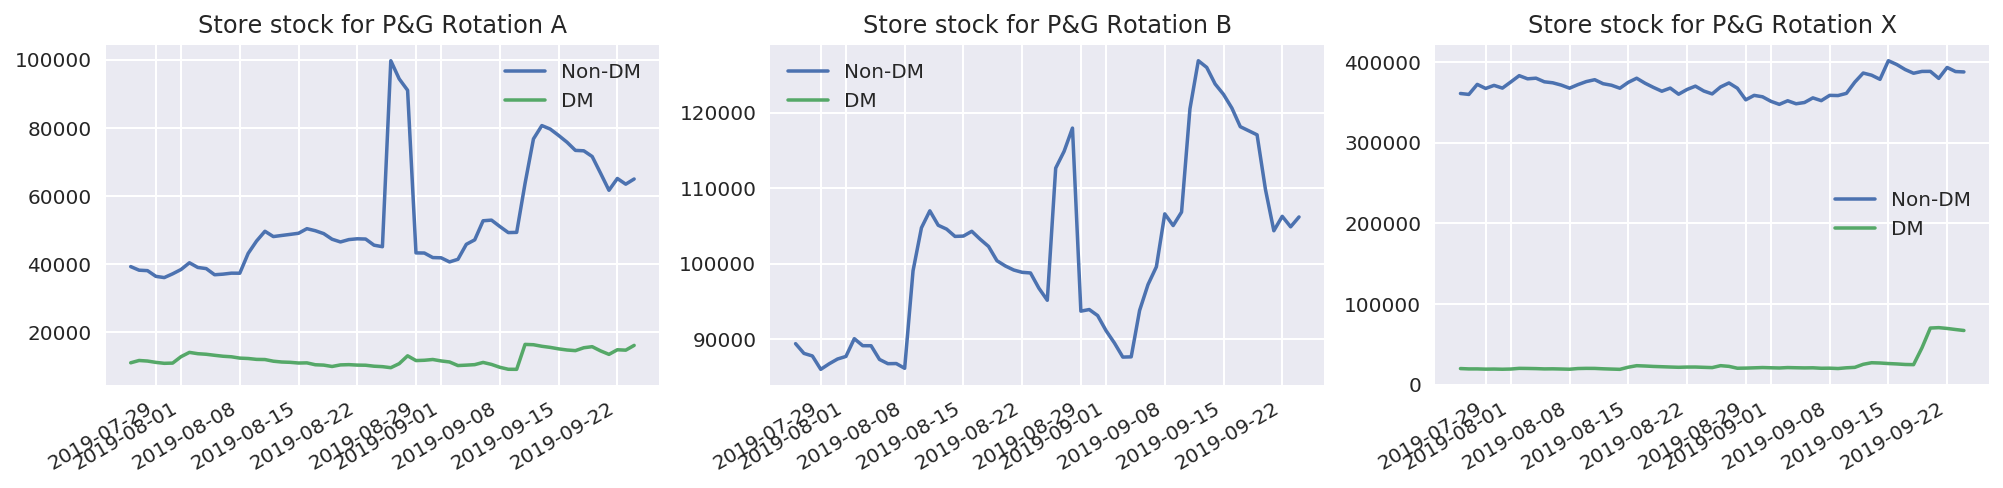

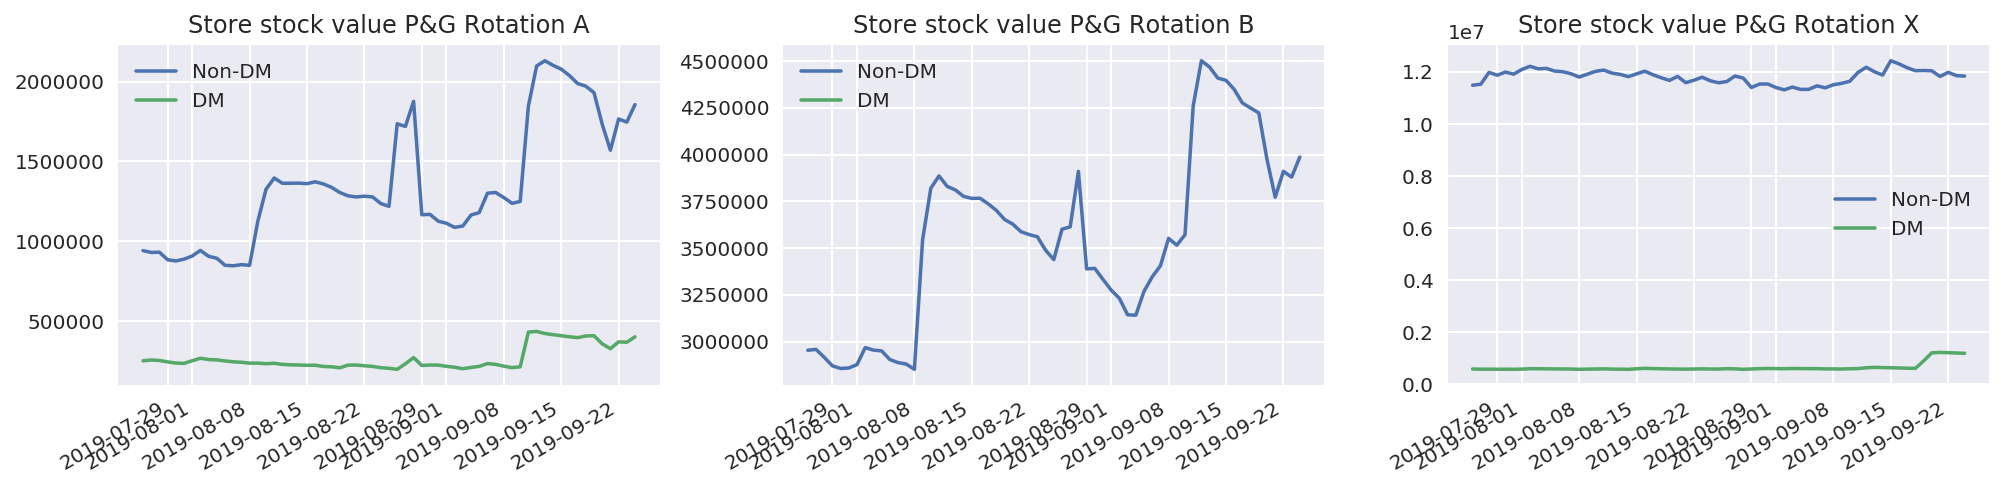

In [48]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '693'], 'P&G')

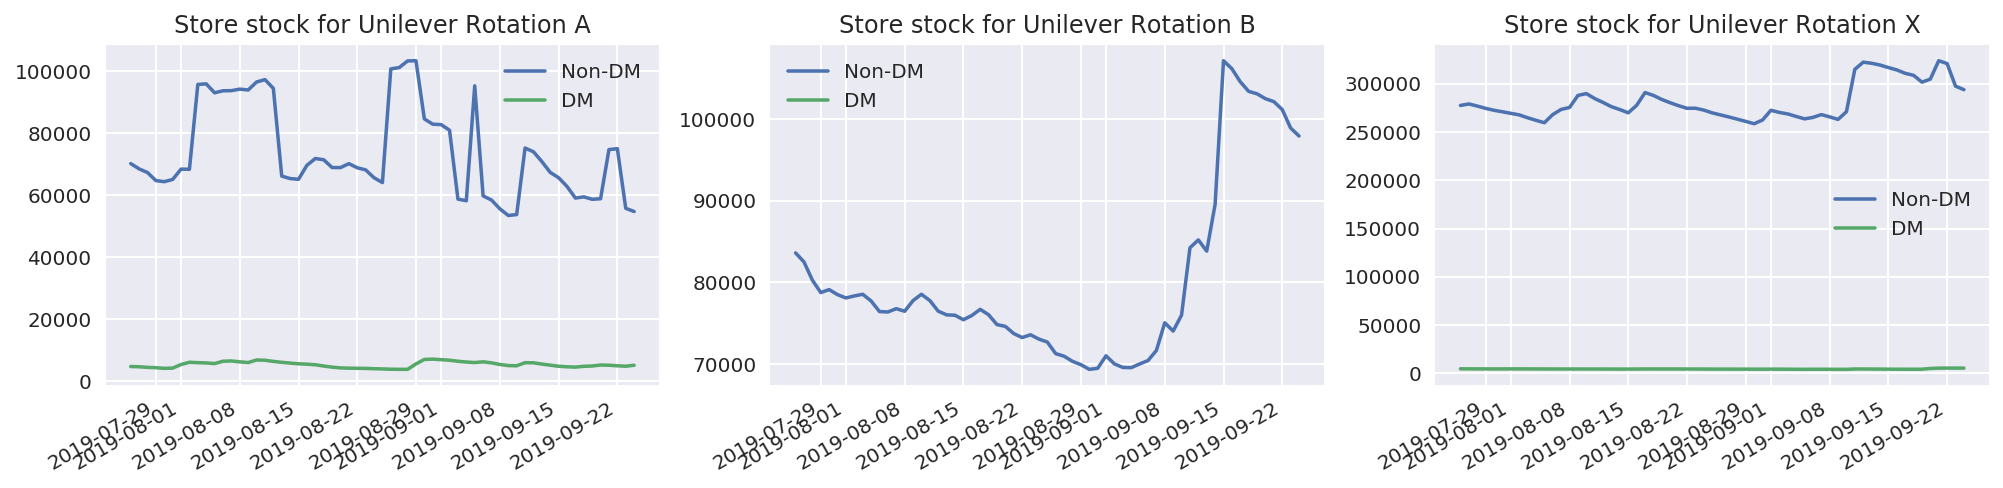

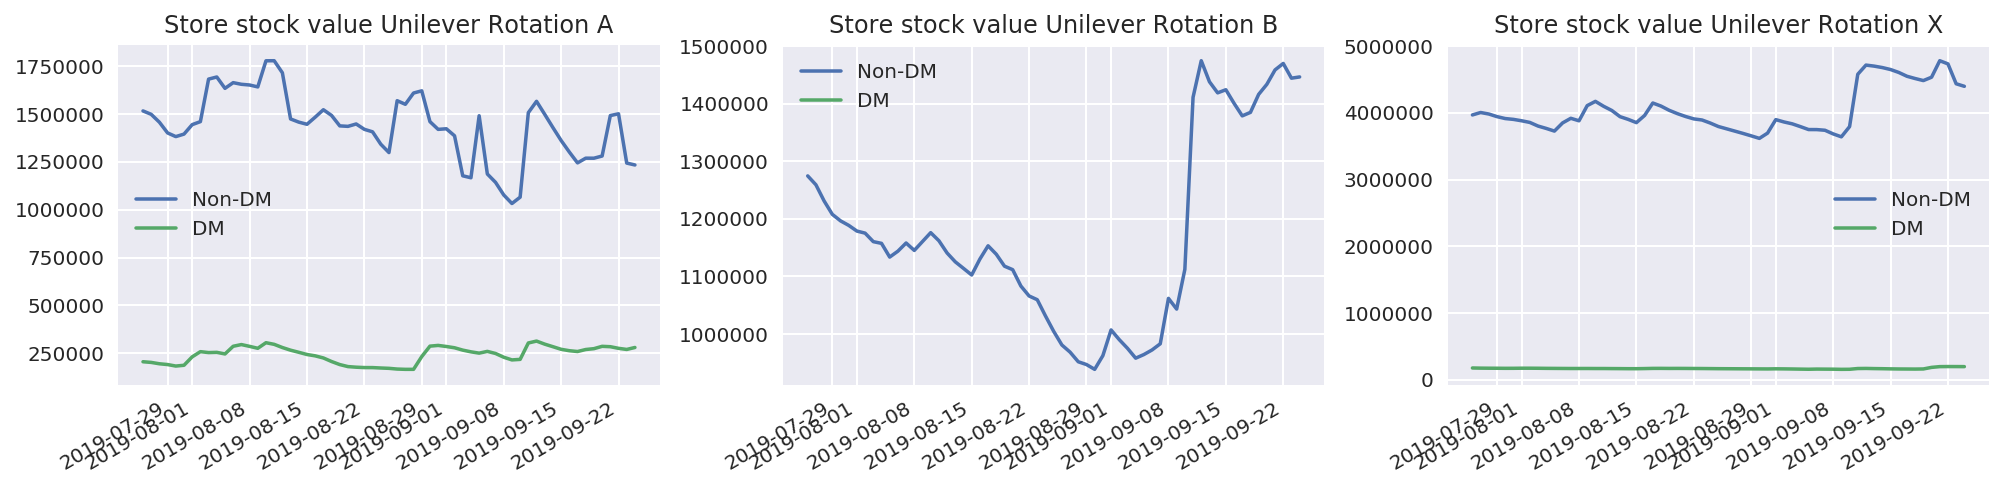

In [49]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '700'], 'Unilever')

In [50]:
stock_store_writer.save()
print(f'Please check file {stock_level_store_file} for detail')

Please check file report_stock_level_store_20190924.xlsx for detail


---

## 3 Service level

### 3.1 Service level - DC

In [51]:
sl_writer = ExcelWriter(record_folder + service_level_file)

In [52]:
SERVICE_LEVEL_START =  '20190820'
SERVICE_LEVEL_END = '20190924'

In [53]:
sl_dc = read_query_and_fetch(
    'sql/kpi_service_level.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
    kudu_replace={'lfms.daily_dctrxn': 'lfms_daily_dctrxn', 'lfms.ord': 'lfms_ord'}
)

In [54]:
def show_service_level_dc(df):
    df1 = df.copy()
    for col in ['trxn_qty_sum', 'basic_order_qty_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')

    df1 = df1.rename(columns={'trxn_qty_sum': 'received_qty_sum', 
                              'basic_order_qty_sum': 'ordered_qty_sum'})
    
    df1.to_excel(sl_writer, sheet_name='DC service level', index=False)
    return df1.groupby('holding_code')[['service_level']].mean().reset_index().style.hide_index()

In [55]:
print('DC service level:')
show_service_level_dc(sl_dc)

DC service level:


holding_code,service_level
002,0.768762
693,0.958314
700,0.860326


### 3.2 Service level - Store

In [56]:
sl_store = read_query_and_fetch(
    'sql/kpi_service_level_store.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
   kudu_replace={'lfms.daily_shipment':'lfms_daily_shipment'}
)

In [57]:
def show_service_level_store(df):
    df1 = df.copy()
    for col in ['order_qty_in_sku_sum', 'delivery_qty_in_sku_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')

    df1 = df1.rename(columns={'delivery_qty_in_sku_sum': 'store_received_qty_sum', 
                              'order_qty_in_sku_sum': 'store_ordered_qty_sum'})
    
    df1.to_excel(sl_writer, sheet_name='Store service level', index=False)
    return df1.groupby(['holding_code', 'piece_picking'])[['service_level']].mean().reset_index().style.hide_index()


In [58]:
print('store service level:')
show_service_level_store(sl_store)

store service level:


holding_code,piece_picking,service_level
002,N,0.701982
693,N,0.800929
693,Y,0.876626
700,N,0.731119
700,Y,1.20174


In [59]:
sl_writer.save()

## 4 Out-of-Stock item list

In [60]:
oos_writer = ExcelWriter(record_folder + oos_file)

In [61]:
oos_item_list_dc = read_query_and_fetch(
    'sql/kpi_oos_item_list_dc.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', oos_check_date=OOS_CHECK_DATE,
    kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [62]:
print(f'{len(oos_item_list_dc)} out of stock DC items found')
oos_item_list_dc.to_excel(oos_writer, sheet_name='Out of stock items in DC', index=False)

31 out of stock DC items found


In [63]:
oos_item_list_store = read_query_and_fetch(
    'sql/kpi_oos_item_list_store.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', oos_check_date=OOS_CHECK_DATE,
    # kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [64]:
oos_item_store = oos_item_list_store.groupby(['store_code'])['full_item_code'].count() \
        .reset_index() \
        .sort_values(by=['full_item_code'], ascending = False) \
        .copy()

oos_item_store.columns = ["Store code", "Number of items out of stock"]

oos_item_store.to_excel(oos_writer, sheet_name='Out of stock in store', index=False)

In [65]:
print("Top 10 stores with most out of stock items")
oos_item_store.head(10)

Top 10 stores with most out of stock items


,Store code,Number of items out of stock
36,163,141
11,118,131
4,111,128
6,113,110
10,117,104
22,144,104
35,160,103
42,188,97
19,134,92
37,166,92


In [66]:
oos_item = oos_item_list_store.groupby(['full_item_code', 'item_id', 'sub_id',
                                        'cn_name', 'rotation', 'ds_supplier_code',
                                       'store_status','dc_status',
                                       'item_stop_start_date', 'item_stop_end_date'])['store_code'].count() \
        .reset_index() \
        .sort_values(by=['store_code'], ascending = False) \
        .copy() \

oos_item.columns = ["Full item code", "Item ID", "Sub ID", 
                    "CN name", 'Rotation', 'DS Supplier Code',
                    "Store status","DC status", 
                    "Stop start date","Stop end date",
                    "Number out of stock stores"]

oos_item.to_excel(oos_writer, sheet_name='Out of stock items', index=False)

In [67]:
print("Top 10 out of stock items")
oos_item.head(10)

Top 10 out of stock items


,Full item code,Item ID,Sub ID,CN name,Rotation,DS Supplier Code,Store status,DC status,Stop start date,Stop end date,Number out of stock stores
346,12281999001,1291698,1387653,潘婷3分钟奢护精华霜染烫修护 180ml,X,ZB09,Active,Stop,,,47
192,12200187001,1282056,1376879,海飞丝男士去屑洗发露劲感净透730ml,X,ZB09,Active,Stop,,,45
88,11140203001,1253930,1344443,奥妙深层洁净洗衣液2kg,X,0031,Active,Active,,,41
513,12421115001,1221389,1306709,欧乐B50米微蜡牙线,X,ZB09,Active,Stop,,,40
193,12200213001,1280206,1374450,清扬男士去屑洗发露清爽控油型蓝瓶cm1000ml,A,0031,Active,Active,,,37
471,12400078001,17692,95678,佳洁士酷白体验冰极山泉口感牙膏,X,ZB09,Active,Stop,,,35
69,11130407001,722635,775080,汰渍全效除菌无磷洗衣粉1.65kg,X,ZB09,Active,Stop,,,33
20,11120010001,1290836,1386769,金纺衣物护理剂纯净温和2.8l,A,0031,Active,Active,,,32
75,11130497001,894714,955549,奥妙全自动含金纺馨香洗衣粉4kg,X,0031,Active,Active,,,32
699,14330885001,44324,127789,雀巢高钙高铁奶粉400g,X,06WC,Active,Active,,,31


In [68]:
print(f'{len(oos_item_list_store)} out of stock store items found')
oos_item_list_store.to_excel(oos_writer, sheet_name='Out of stock items in store', index=False)

3636 out of stock store items found


In [69]:
no_predict_item_store = oos_item_list_store[oos_item_list_store["sales_prediction"] < 0]

In [70]:
no_predict_item = no_predict_item_store[['full_item_code', 'item_id', 'sub_id', 
                                         'cn_name', 'rotation', 'con_holding', 'ds_supplier_code',
                                        'store_status','dc_status',
                                        'item_stop_start_date', 'item_stop_end_date']] \
                    .drop_duplicates()

In [71]:
print("Items that does not have sales prediction")
no_predict_item.to_excel(oos_writer, sheet_name='No sales prediction item', index=False)
no_predict_item

Items that does not have sales prediction


,full_item_code,item_id,sub_id,cn_name,rotation,con_holding,ds_supplier_code,store_status,dc_status,item_stop_start_date,item_stop_end_date
15,12100113001,40448,92667,82106834玉兰油乳液嫩白洁面乳150g,X,693,ZB09,Active,Active,,
31,12631019001,378355,411605,护舒宝瞬洁贴身甜睡400（6 片）,X,693,ZB09,Active,Active,,
35,11140203001,1253930,1344443,奥妙深层洁净洗衣液2kg,X,700,0031,Active,Active,,
199,12400430001,1128236,1202708,中华健齿白炫动果香味200g,A,700,0031,Active,Active,,
251,12310133001,19926,186900,63361 玉兰油深度滋润香皂（普通型）100g,X,693,ZB09,Active,Active,,
335,12414036001,905967,967565,佳洁士三重护理牙刷三支八折超值装,X,693,ZB09,Active,Active,,
383,12114116001,28397,95474,10167 玉兰油多效修护霜50g,X,693,ZB09,Active,Active,,
430,12631065001,925845,987900,护舒宝甜睡棉柔317丝薄卫生巾8片,X,693,ZB09,Active,Active,,
472,12630272001,21791,71988,82100103护舒宝瞬洁贴身日用卫生巾,B,693,ZB09,Active,Active,,
514,12712097001,746268,800606,帮宝适超薄干爽中包装中号,X,693,ZB09,Active,Stop,,


In [72]:
oos_writer.save()
print(f'Please check file {oos_file} for detail')

Please check file report_oos_item_list_20190924.xlsx for detail


In [73]:
T1 = time.time()

---

In [74]:
print(f'Generating monitoring report takes {T1-T0:.2f} seconds.')

Generating monitoring report takes 268.05 seconds.
